In [85]:
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision import models
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
#from einops import rearrange, repeat
#from einops.layers.torch import Rearrange
import math
import numpy as np
import time
from torch import einsum
import cv2
import scipy.misc
#import utils
import tqdm
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

In [86]:
import pandas as pd

#file_path = "../simulate_data/squat_data.csv"
file_path = "squat_data.csv"

df = pd.read_csv(file_path)

print(df.head())

   updown       UWB     vel_x     vel_y     vel_z     accel_x     accel_y  \
0       0  1.711766  0.000000  0.000000  0.000000   11.828938  -47.956334   
1       0  1.711567  0.032885 -0.103377  0.085973  161.323707  -58.555513   
2       0  1.707675  0.814416 -0.361158 -0.095207 -178.527859  131.141650   
3       0  1.706877 -0.014801  0.076857 -0.414512  167.629076 -131.972570   
4       0  1.702809  0.778336 -0.387729 -0.164145 -152.167755   50.021166   

      accel_z    gyro_x    gyro_y    gyro_z  
0   62.560536  0.000000  0.000000  0.000000  
1  -18.781445  1.277550  0.196830 -0.315507  
2 -121.957382  0.458584  2.095545 -2.194921  
3  115.180361 -2.522667  1.956186  0.759899  
4   -3.156194  1.050402  2.661206 -2.515833  


In [87]:
df = df.drop(columns=['vel_x', 'vel_y', 'vel_z'])

In [175]:
tmp = df['updown'].shift(1).fillna(0)
squat_ends = df[(tmp == 1) & (df['updown'] == 0)].index
print(f"Total squat ends: {len(squat_ends)}")

squat_sets = []

start_index = 0
for end_index in squat_ends:
    one_set = df.iloc[start_index:end_index+1]

    if len(one_set) > 140:
        one_set = one_set.tail(140)
        squat_sets.append(one_set)
    else:
        print(f"Set too short: {len(one_set)}")

    #squat_sets.append(one_set)
    start_index = end_index + 1

print(f"Total sets: {len(squat_sets)}")

Total squat ends: 3000
Set too short: 140
Set too short: 140
Set too short: 138
Set too short: 135
Set too short: 139
Set too short: 140
Set too short: 138
Total sets: 2993


In [397]:
# 한 sample당 15frames (현재 포함 과거 10개, 미래 5개), stride 5
X = []
y = []
for one_set in squat_sets:
    for i in range(0, len(one_set) - 14, 5):
        X.append(one_set.iloc[i:i+15, 1:].values)
        y.append(one_set.iloc[i+14]['updown'])

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(77818, 15, 7) (77818,)


In [398]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        #out = self.fc(out[:, 10, :]) # 과거 10개, 현재 5개
        out = self.fc(out[:, -1, :]) # 과거 15개개

        return out

In [399]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [400]:
import torch.nn.init as init
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

def initialize_gru_weights(lstm):
    for name, param in lstm.named_parameters():
        if 'weight' in name:
            init.xavier_uniform_(param.data)
        elif 'bias' in name:
            init.constant_(param.data, 0)

# 초기화 실행
set_seed(42)
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
model.apply(initialize_weights)
initialize_gru_weights(model.lstm)

In [401]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Training set size: 62254
Validation set size: 7782
Testing set size: 7782
(62254, 15, 7)
(7782, 15, 7)
(7782, 15, 7)


In [402]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [403]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [404]:
print(model)

LSTM(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [405]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [406]:
def evaluate(model, data_loader, criterion, device, phase="validation"):
    global best_val_acc
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"Evaluating {phase}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Accuracy: {accuracy:.2f}%")
    if phase == "validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
    if phase == "test":
        test_accuracy = accuracy
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        f1_score_result = f1_score(all_labels, all_predictions)
        recall_score_result = recall_score(all_labels, all_predictions)
        precision_score_result = precision_score(all_labels, all_predictions)

        return f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions


In [407]:
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="validation")

Epoch [1/50]


Train Loss: 0.0066, Train Accuracy: 90.37%


Validation Loss: 0.0036, Validation Accuracy: 95.52%
Best model saved!
Epoch [2/50]


Train Loss: 0.0030, Train Accuracy: 96.32%


Validation Loss: 0.0027, Validation Accuracy: 96.39%
Best model saved!
Epoch [3/50]


Train Loss: 0.0021, Train Accuracy: 97.44%


Validation Loss: 0.0018, Validation Accuracy: 98.09%
Best model saved!
Epoch [4/50]


Train Loss: 0.0017, Train Accuracy: 98.03%


Validation Loss: 0.0016, Validation Accuracy: 98.32%
Best model saved!
Epoch [5/50]


Train Loss: 0.0014, Train Accuracy: 98.31%


Validation Loss: 0.0019, Validation Accuracy: 98.28%
Epoch [6/50]


Train Loss: 0.0012, Train Accuracy: 98.55%


Validation Loss: 0.0013, Validation Accuracy: 98.46%
Best model saved!
Epoch [7/50]


Train Loss: 0.0011, Train Accuracy: 98.70%


Validation Loss: 0.0012, Validation Accuracy: 98.75%
Best model saved!
Epoch [8/50]


Train Loss: 0.0010, Train Accuracy: 98.84%


Validation Loss: 0.0016, Validation Accuracy: 98.52%
Epoch [9/50]


Train Loss: 0.0009, Train Accuracy: 98.91%


Validation Loss: 0.0011, Validation Accuracy: 98.79%
Best model saved!
Epoch [10/50]


Train Loss: 0.0009, Train Accuracy: 98.97%


Validation Loss: 0.0010, Validation Accuracy: 98.87%
Best model saved!
Epoch [11/50]


Train Loss: 0.0008, Train Accuracy: 98.99%


Validation Loss: 0.0011, Validation Accuracy: 98.69%
Epoch [12/50]


Train Loss: 0.0007, Train Accuracy: 99.07%


Validation Loss: 0.0010, Validation Accuracy: 98.92%
Best model saved!
Epoch [13/50]


Train Loss: 0.0007, Train Accuracy: 99.10%


Validation Loss: 0.0009, Validation Accuracy: 98.87%
Epoch [14/50]


Train Loss: 0.0007, Train Accuracy: 99.16%


Validation Loss: 0.0010, Validation Accuracy: 98.95%
Best model saved!
Epoch [15/50]


Train Loss: 0.0006, Train Accuracy: 99.17%


Validation Loss: 0.0008, Validation Accuracy: 99.01%
Best model saved!
Epoch [16/50]


Train Loss: 0.0006, Train Accuracy: 99.23%


Validation Loss: 0.0009, Validation Accuracy: 99.04%
Best model saved!
Epoch [17/50]


Train Loss: 0.0006, Train Accuracy: 99.26%


Validation Loss: 0.0011, Validation Accuracy: 98.79%
Epoch [18/50]


Train Loss: 0.0006, Train Accuracy: 99.27%


Validation Loss: 0.0009, Validation Accuracy: 98.96%
Epoch [19/50]


Train Loss: 0.0005, Train Accuracy: 99.29%


Validation Loss: 0.0008, Validation Accuracy: 98.96%
Epoch [20/50]


Train Loss: 0.0005, Train Accuracy: 99.38%


Validation Loss: 0.0008, Validation Accuracy: 99.04%
Epoch [21/50]


Train Loss: 0.0005, Train Accuracy: 99.38%


Validation Loss: 0.0009, Validation Accuracy: 99.00%
Epoch [22/50]


Train Loss: 0.0005, Train Accuracy: 99.39%


Validation Loss: 0.0009, Validation Accuracy: 99.14%
Best model saved!
Epoch [23/50]


Train Loss: 0.0005, Train Accuracy: 99.41%


Validation Loss: 0.0009, Validation Accuracy: 99.01%
Epoch [24/50]


Train Loss: 0.0004, Train Accuracy: 99.45%


Validation Loss: 0.0008, Validation Accuracy: 99.01%
Epoch [25/50]


Train Loss: 0.0004, Train Accuracy: 99.51%


Validation Loss: 0.0008, Validation Accuracy: 99.19%
Best model saved!
Epoch [26/50]


Train Loss: 0.0004, Train Accuracy: 99.49%


Validation Loss: 0.0009, Validation Accuracy: 99.00%
Epoch [27/50]


Train Loss: 0.0003, Train Accuracy: 99.53%


Validation Loss: 0.0009, Validation Accuracy: 99.06%
Epoch [28/50]


Train Loss: 0.0003, Train Accuracy: 99.53%


Validation Loss: 0.0009, Validation Accuracy: 99.07%
Epoch [29/50]


Train Loss: 0.0003, Train Accuracy: 99.52%


Validation Loss: 0.0008, Validation Accuracy: 99.07%
Epoch [30/50]


Train Loss: 0.0003, Train Accuracy: 99.59%


Validation Loss: 0.0008, Validation Accuracy: 99.07%
Epoch [31/50]


Train Loss: 0.0003, Train Accuracy: 99.63%


Validation Loss: 0.0009, Validation Accuracy: 99.09%
Epoch [32/50]


Train Loss: 0.0003, Train Accuracy: 99.61%


Validation Loss: 0.0008, Validation Accuracy: 99.23%
Best model saved!
Epoch [33/50]


Train Loss: 0.0003, Train Accuracy: 99.64%


Validation Loss: 0.0009, Validation Accuracy: 99.06%
Epoch [34/50]


Train Loss: 0.0003, Train Accuracy: 99.68%


Validation Loss: 0.0010, Validation Accuracy: 99.09%
Epoch [35/50]


Train Loss: 0.0003, Train Accuracy: 99.65%


Validation Loss: 0.0010, Validation Accuracy: 99.04%
Epoch [36/50]


Train Loss: 0.0002, Train Accuracy: 99.70%


Validation Loss: 0.0008, Validation Accuracy: 99.19%
Epoch [37/50]


Train Loss: 0.0003, Train Accuracy: 99.66%


Validation Loss: 0.0010, Validation Accuracy: 99.15%
Epoch [38/50]


Train Loss: 0.0002, Train Accuracy: 99.74%


Validation Loss: 0.0009, Validation Accuracy: 99.10%
Epoch [39/50]


Train Loss: 0.0002, Train Accuracy: 99.72%


Validation Loss: 0.0009, Validation Accuracy: 99.23%
Epoch [40/50]


Train Loss: 0.0002, Train Accuracy: 99.75%


Validation Loss: 0.0009, Validation Accuracy: 99.16%
Epoch [41/50]


Train Loss: 0.0002, Train Accuracy: 99.76%


Validation Loss: 0.0010, Validation Accuracy: 99.24%
Best model saved!
Epoch [42/50]


Train Loss: 0.0002, Train Accuracy: 99.75%


Validation Loss: 0.0009, Validation Accuracy: 99.16%
Epoch [43/50]


Train Loss: 0.0002, Train Accuracy: 99.77%


Validation Loss: 0.0010, Validation Accuracy: 99.10%
Epoch [44/50]


Train Loss: 0.0002, Train Accuracy: 99.79%


Validation Loss: 0.0011, Validation Accuracy: 99.07%
Epoch [45/50]


Train Loss: 0.0002, Train Accuracy: 99.80%


Validation Loss: 0.0009, Validation Accuracy: 99.19%
Epoch [46/50]


Train Loss: 0.0002, Train Accuracy: 99.80%


Validation Loss: 0.0011, Validation Accuracy: 99.10%
Epoch [47/50]


Train Loss: 0.0002, Train Accuracy: 99.80%


Validation Loss: 0.0010, Validation Accuracy: 99.19%
Epoch [48/50]


Train Loss: 0.0002, Train Accuracy: 99.80%


Validation Loss: 0.0009, Validation Accuracy: 99.19%
Epoch [49/50]


Train Loss: 0.0001, Train Accuracy: 99.83%


Validation Loss: 0.0009, Validation Accuracy: 99.18%
Epoch [50/50]


Train Loss: 0.0002, Train Accuracy: 99.81%


Validation Loss: 0.0010, Validation Accuracy: 99.14%


In [409]:
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="test")

Test Loss: 0.0013, Test Accuracy: 98.84%
Test Accuracy: 98.84%


In [410]:
print(f"F1 Score: {f1_score_result:.4f}")
print(f"Recall Score: {recall_score_result:.4f}")
print(f"Precision Score: {precision_score_result:.4f}")

F1 Score: 0.9911
Recall Score: 0.9873
Precision Score: 0.9948


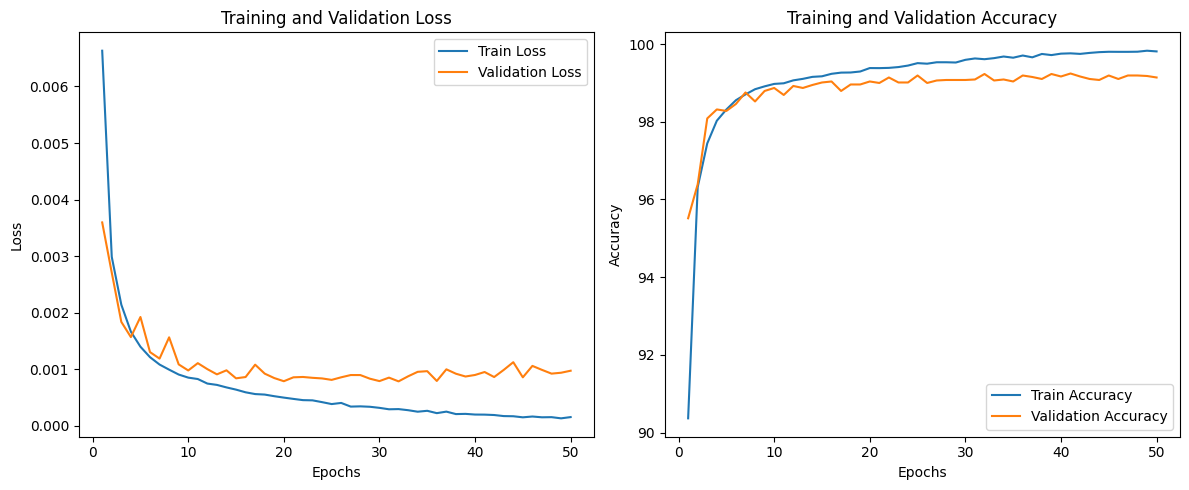

In [411]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss}
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [412]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [413]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 244
Average Time: 0.58 ms
Standard Deviation: 0.07 ms
Maximum Time: 0.91 ms
Minimum Time: 0.53 ms
